In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
import pyspark as ps
import pyspark.sql.functions as f
from pyspark import SQLContext
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, precision_score, roc_curve
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import pickle

In [2]:
spark = ps.sql.SparkSession.builder.master('local[4]').appName('Text-mining').getOrCreate() #creating spark object

In [3]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)  #initializing spark context

In [4]:
data = pd.read_table('SMSSpamCollection')
data.columns = ['class', 'message']
print('Shape of dataset ',data.shape)
print(data['class'].value_counts())
data.head()

Shape of dataset  (5571, 2)
ham     4824
spam     747
Name: class, dtype: int64


,class,message
0,ham,Ok lar... Joking wif u oni...
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
2,ham,U dun say so early hor... U c already then say...
3,ham,"Nah I don't think he goes to usf, he lives aro..."
4,spam,FreeMsg Hey there darling it's been 3 week's n...


In [5]:
spam = data[data['class'] == 'spam'] #filtering spam to check
spam.head()

,class,message
1,spam,Free entry in 2 a wkly comp to win FA Cup fina...
4,spam,FreeMsg Hey there darling it's been 3 week's n...
7,spam,WINNER!! As a valued network customer you have...
8,spam,Had your mobile 11 months or more? U R entitle...
10,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   class    5571 non-null   object
 1   message  5571 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [7]:
words = sc.textFile('/home/bluearc/Projects/Text Mining/Word.txt').flatMap(lambda x: x.split())

#been getting linux conf internal errors trying to collect content of file Word.txt, so i'm resorting to reading the file with the read function

In [8]:
with open('Word.txt', 'r') as f: #opening file containing spam trigger words
    spam_words = f.read() #reading file and storing it as text

In [10]:
'''
This cell is basically to check if any of the messages in the data contains any one of spam trigger words in the Word.txt file
it checks the message one by one and if there are any spam trigger words in it, returns true else returns false and appends to a target list as
indicated empty
'''
target = []
for sentence in data.message.values:
    if any(word in sentence.lower().split() for word in spam_words.lower().split(', ')):
        target.append(str(bool(True)))
    else:
        target.append(str(bool(False)))
        
list_set = set(target)
    # convert the set to the list
unique_list = (list(list_set))
for y in unique_list:
    print(y)

False
True


In [11]:
dataset = data.drop('class', axis=1)
dataset['Target'] = target
print(dataset.Target.value_counts())
dataset.head()

False    3654
True     1917
Name: Target, dtype: int64


,message,Target
0,Ok lar... Joking wif u oni...,False
1,Free entry in 2 a wkly comp to win FA Cup fina...,True
2,U dun say so early hor... U c already then say...,False
3,"Nah I don't think he goes to usf, he lives aro...",True
4,FreeMsg Hey there darling it's been 3 week's n...,True


In [12]:
#checking for messages which have all capital letters and label them True, i.e  Spam
dataset.loc[data['message'].str.isupper(), ['Target']] = str(bool(True))
print(dataset.Target.value_counts()) #check value counts and notice change

False    3577
True     1994
Name: Target, dtype: int64


In [13]:
#Changing the class label names from True and False to Spam and Inbox and splitting the dataset into two for training and testing
conditions = [dataset['Target']=='True',
              dataset['Target']=="False"
             ]
choices = ['Spam',
           'Inbox'
        ]
dataset['Class'] = np.select(conditions, choices)
dataset.drop('Target', axis=1, inplace=True)
train_data, test_data = np.split(dataset.sample(frac=1, random_state=1), [int(0.90*len(dataset))])
# train_data.to_csv('SMStrainData.csv')
# test_data.to_csv('SMStestData.csv')
print(train_data.shape, test_data.shape)
train_data.head()

(5013, 2) (558, 2)


,message,Class
745,Dunno he jus say go lido. Same time 930.,Inbox
3042,Slaaaaave ! Where are you ? Must I summon you ...,Spam
1928,Call from 08702490080 - tells u 2 call 0906635...,Spam
2641,"You are guaranteed the latest Nokia Phone, a 4...",Spam
605,TaKe CaRE n gET WeLL sOOn,Spam


In [14]:
train_data = train_data.reset_index(drop=True) #reset index
train_data.head()

,message,Class
0,Dunno he jus say go lido. Same time 930.,Inbox
1,Slaaaaave ! Where are you ? Must I summon you ...,Spam
2,Call from 08702490080 - tells u 2 call 0906635...,Spam
3,"You are guaranteed the latest Nokia Phone, a 4...",Spam
4,TaKe CaRE n gET WeLL sOOn,Spam


In [15]:
#prepping the data for machine learning, removing punctuation and stop words
def text_cleaning(text):
    remove_punctuation = [char for char in text if char not in string.punctuation] #removing punctuation from each message
    remove_punctuation = ''.join(remove_punctuation) #joins each word back to make a sentence
    return [word for word in remove_punctuation.split() if word.lower() not in stopwords.words('english')] #eliminate english stop words

In [16]:
x = train_data['message']
y = train_data['Class']

vectorizer = CountVectorizer(analyzer=text_cleaning).fit(x) #Vectorizing and counting words for each sample
vector = vectorizer.transform(x)

tfidf = TfidfTransformer().fit(vector) #TF-IDF Term Frequency Inverse Document Frequency, to find out the most important words in a sample
X = tfidf.transform(vector)

In [17]:
y = y.map({'Spam':0, 'Inbox':1}) #label encoding, encoding the target feature

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) #spilt the data

In [19]:
#SMOTE for handling inbalanced classification
#you prolly might be wondering why its done after the split here, but I've made some research and found its best be done after the split
smot = SMOTE(sampling_strategy='minority')
x_new, y_new = smot.fit_resample(x_train, y_train)

#### Building the Models

In [20]:
#creating object of the various algorithms to be used

lg = LogisticRegression(random_state=0)
rf = RandomForestClassifier(random_state=1)
xg = xgb.XGBClassifier(max_depth=4, eta=0.3, objective='multi:softmax', num_class=2)
dt = DecisionTreeClassifier(random_state=1)
gn = GaussianNB()
mn = MultinomialNB()
gb = GradientBoostingClassifier(random_state=1)
ab = AdaBoostClassifier()

In [21]:
lg.fit(x_new,y_new)
lg_pred = lg.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), lg_pred))
print('Precision score', precision_score(list(y_test.values), lg_pred))
print('Recall score', recall_score(list(y_test.values), lg_pred))
print('F1 score', f1_score(list(y_test.values), lg_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), lg_pred))

Accuracy score 0.8654037886340977
Precision score 0.8797736916548797
Recall score 0.9255952380952381
F1 score 0.9021029731689629
Confusion Matrix: 
 [[246  85]
 [ 50 622]]


In [22]:
rf.fit(x_new,y_new)
rf_pred = rf.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), rf_pred))
print('Precision score', precision_score(list(y_test.values), rf_pred))
print('Recall score', recall_score(list(y_test.values), rf_pred))
print('F1 score', f1_score(list(y_test.values), rf_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), rf_pred))

Accuracy score 0.909272183449651
Precision score 0.9144079885877318
Recall score 0.9538690476190477
F1 score 0.9337217771303714
Confusion Matrix: 
 [[271  60]
 [ 31 641]]


In [23]:
xg.fit(x_new,y_new)
xg_pred = xg.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), xg_pred))
print('Precision score', precision_score(list(y_test.values), xg_pred))
print('Recall score', recall_score(list(y_test.values), xg_pred))
print('F1 score', f1_score(list(y_test.values), xg_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), xg_pred))

[10:46:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score 0.8943170488534397
Precision score 0.9077809798270894
Recall score 0.9375
F1 score 0.9224011713030746
Confusion Matrix: 
 [[267  64]
 [ 42 630]]


In [24]:
dt.fit(x_new,y_new)
dt_pred = dt.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), dt_pred))
print('Precision score', precision_score(list(y_test.values), dt_pred))
print('Recall score', recall_score(list(y_test.values), dt_pred))
print('F1 score', f1_score(list(y_test.values), dt_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), dt_pred))

Accuracy score 0.8693918245264207
Precision score 0.9117199391171994
Recall score 0.8913690476190477
F1 score 0.9014296463506396
Confusion Matrix: 
 [[273  58]
 [ 73 599]]


In [25]:
gn.fit(x_new.toarray(),y_new)
gn_pred = gn.predict(x_test.toarray())
print('Accuracy score', accuracy_score(list(y_test.values), gn_pred))
print('Precision score', precision_score(list(y_test.values), gn_pred))
print('Recall score', recall_score(list(y_test.values), gn_pred))
print('F1 score', f1_score(list(y_test.values), gn_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), gn_pred))

Accuracy score 0.5982053838484547
Precision score 0.7843551797040169
Recall score 0.5520833333333334
F1 score 0.6480349344978167
Confusion Matrix: 
 [[229 102]
 [301 371]]


In [26]:
mn.fit(x_new,y_new)
mn_pred = mn.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), mn_pred))
print('Precision score', precision_score(list(y_test.values), mn_pred))
print('Recall score', recall_score(list(y_test.values), mn_pred))
print('F1 score', f1_score(list(y_test.values), mn_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), mn_pred))

Accuracy score 0.8255234297108675
Precision score 0.865979381443299
Recall score 0.875
F1 score 0.8704663212435233
Confusion Matrix: 
 [[240  91]
 [ 84 588]]


In [27]:
gb.fit(x_new.toarray(),y_new)
gb_pred = gb.predict(x_test.toarray())
print('Accuracy score', accuracy_score(list(y_test.values), gb_pred))
print('Precision score', precision_score(list(y_test.values), gb_pred))
print('Recall score', recall_score(list(y_test.values), gb_pred))
print('F1 score', f1_score(list(y_test.values), gb_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), gb_pred))

Accuracy score 0.8783649052841476
Precision score 0.8787878787878788
Recall score 0.9494047619047619
F1 score 0.9127324749642345
Confusion Matrix: 
 [[243  88]
 [ 34 638]]


In [28]:
ab.fit(x_new,y_new)
ab_pred = ab.predict(x_test)
print('Accuracy score', accuracy_score(list(y_test.values), ab_pred))
print('Precision score', precision_score(list(y_test.values), ab_pred))
print('Recall score', recall_score(list(y_test.values), ab_pred))
print('F1 score', f1_score(list(y_test.values), ab_pred))
print('Confusion Matrix: \n', confusion_matrix(list(y_test.values), ab_pred))

Accuracy score 0.8753738783649053
Precision score 0.9051851851851852
Recall score 0.9092261904761905
F1 score 0.907201187824796
Confusion Matrix: 
 [[267  64]
 [ 61 611]]


#### Plotting ROC curve for each classifier to visualize the performance of each model

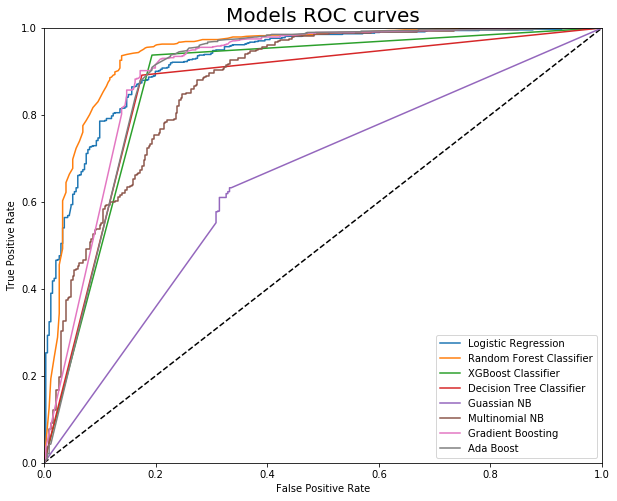

In [29]:
lg_score = lg.decision_function(x_test)
rf_score = rf.predict_proba(x_test)[:,1]
xg_score = xg.predict_proba(x_test)[:,1]
dt_score = dt.predict_proba(x_test)[:,1]
gn_score = gn.predict_proba(x_test.toarray())[:,1]
mn_score = mn.predict_proba(x_test)[:,1]
gb_score = gb.predict_proba(x_test)[:,1]
ab_score = ab.predict_proba(x_test)[:,1]

# Getting the ROC curve for each classifier used
fpr_lg, tpr_lg, threshold_lg = roc_curve(y_test.values, lg_score)
fpr_rf, tpr_rf, threshold_rf = roc_curve(y_test.values, rf_score)
fpr_xg, tpr_xg, threshold_xg = roc_curve(y_test.values, xg_score)
fpr_dt, tpr_dt, threshold_dt = roc_curve(y_test.values, dt_score)
fpr_gn, tpr_gn, threshold_gn = roc_curve(y_test.values, gn_score)
fpr_mn, tpr_mn, threshold_mn = roc_curve(y_test.values, mn_score)
fpr_gb, tpr_gb, threshold_gb = roc_curve(y_test.values, gb_score)
fpr_ab, tpr_ab, threshold_ab = roc_curve(y_test.values, ab_score)

#plotting each in curve in a single plot for better understanding
plt.figure(figsize=(10,8))
plt.plot([0,1], [0,1], color='k', linestyle='--')
plt.plot(fpr_lg, tpr_lg, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest Classifier')
plt.plot(fpr_xg, tpr_xg, label='XGBoost Classifier')
plt.plot(fpr_dt, tpr_dt, label='Decision Tree Classifier')
plt.plot(fpr_gn, tpr_gn, label='Guassian NB')
plt.plot(fpr_mn, tpr_mn, label='Multinomial NB')
plt.plot(fpr_gb, tpr_gb, label='Gradient Boosting')
plt.plot(fpr_ab, tpr_ab, label='Ada Boost')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('Models ROC curves', fontsize=20)
plt.xlabel("False Positive Rate")
plt.ylabel('True Positive Rate')

plt.legend()

Confusion Matrix:
 [[271  60]
 [ 31 641]]


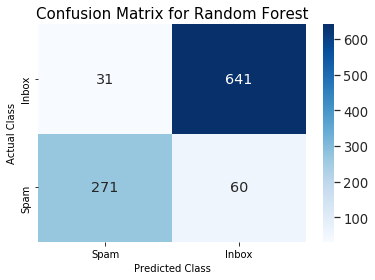

In [30]:
#Visualizing confusion matrix for Random Foresst Classifier
xticks=['Spam', 'Inbox']
yticks=['Spam', 'Inbox']
conf_m = confusion_matrix(list(y_test.values), rf_pred)
print('Confusion Matrix:\n',conf_m)
plt.figure()
plt.title('Confusion Matrix for Random Forest', fontsize=15)
sns.set(font_scale=1.2)
ax=sns.heatmap(conf_m, fmt='d', xticklabels=xticks, yticklabels=yticks, annot=True, cmap='Blues')
ax.set_ylim([0,2])
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [31]:
#Checking the performance of the RandomForest XGBoost after scaling  
scaler = StandardScaler(with_mean=False)
scaler.fit(X)
scaled_X = scaler.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=1)

smot = SMOTE(sampling_strategy='minority')
X_new, Y_new = smot.fit_resample(X_train, Y_train)

In [33]:
xg.fit(X_new,Y_new)
new_xg_pred = xg.predict(X_test)
print('Accuracy score', accuracy_score(list(Y_test.values), new_xg_pred))
print('Precision score', precision_score(list(Y_test.values), new_xg_pred))
print('Recall score', recall_score(list(Y_test.values), new_xg_pred))
print('F1 score', f1_score(list(Y_test.values), new_xg_pred))
print('Confusion Matrix: \n', confusion_matrix(list(Y_test.values), new_xg_pred))

[11:07:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy score 0.8933200398803589
Precision score 0.900709219858156
Recall score 0.9449404761904762
F1 score 0.9222948438634713
Confusion Matrix: 
 [[261  70]
 [ 37 635]]


In [34]:
rf.fit(X_new,Y_new)
new_rf_pred = rf.predict(X_test)
print('Accuracy score', accuracy_score(list(Y_test.values), new_rf_pred))
print('Precision score', precision_score(list(Y_test.values), new_rf_pred))
print('Recall score', recall_score(list(Y_test.values), new_rf_pred))
print('F1 score', f1_score(list(Y_test.values), new_rf_pred))
print('Confusion Matrix: \n', confusion_matrix(list(Y_test.values), new_rf_pred))

Accuracy score 0.909272183449651
Precision score 0.9144079885877318
Recall score 0.9538690476190477
F1 score 0.9337217771303714
Confusion Matrix: 
 [[271  60]
 [ 31 641]]


###### ok will definitely go with the unscaled X as the evalution metric seems better or probably the same without scaling

###### Hyperparameter optimization for RandomForest and XGBoost for Model Optimization

In [35]:
params = {'n_estimators':[100, 200, 300, 400, 500],
         'criterion': ['gini', 'entropy'],
         'max_depth': list(np.arange(8)),
         'n_jobs': [-1,1,2,3,4,5],
          'verbose': [0,1,2,3,4,5,6]
         }
rf_ops = RandomizedSearchCV(rf, param_distributions=params, n_iter=5, n_jobs=-1, cv=5, verbose=0)
rf_ops.fit(x_new, y_new)

print(rf_ops.best_params_)
print('Accuracy score ',accuracy_score(list(y_test.values), rf_ops.predict(x_test)))
print('Precision score ',precision_score(list(y_test.values),rf_ops.predict(x_test)))
print('Recall score ',recall_score(list(y_test.values),rf_ops.predict(x_test)))
print('F1 score ',f1_score(list(y_test.values),rf_ops.predict(x_test)))
print('Confusion Matrix:\n ',confusion_matrix(list(y_test.values),rf_ops.predict(x_test)))

[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s


building tree 1 of 500
building tree 2 of 500
building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500building tree 14 of 500

building tree 15 of 500
building tree 16 of 500
building tree 17 of 500building tree 18 of 500

building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
b

[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.3s




building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500
building tree 195 of 500
building tree 196 of 500
building tree 197 of 500
building tree 198 of 500
building tree 199 of 500building tree 200 of 500

building tree 201 of 500
building tree 202 of 500
building tree 203 of 500
building tree 204 of 500
building tree 205 of 500
building tree 206 of 500
building tree 207 of 500
building tree 208 of 500
building tree 209 of 500building tree 210 of 500

building tree 211 of 500
building tree 212 of 500
building tree 213 of 50

[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.5s


building tree 252 of 500
building tree 253 of 500
building tree 254 of 500
building tree 255 of 500building tree 256 of 500

building tree 257 of 500
building tree 258 of 500
building tree 259 of 500
building tree 260 of 500
building tree 261 of 500
building tree 262 of 500
building tree 263 of 500building tree 264 of 500

building tree 265 of 500building tree 266 of 500

building tree 267 of 500building tree 268 of 500

building tree 269 of 500
building tree 270 of 500
building tree 271 of 500
building tree 272 of 500
building tree 273 of 500
building tree 274 of 500building tree 275 of 500

building tree 276 of 500
building tree 277 of 500
building tree 278 of 500
building tree 279 of 500
building tree 280 of 500
building tree 281 of 500
building tree 282 of 500
building tree 283 of 500
building tree 284 of 500
building tree 285 of 500
building tree 286 of 500
building tree 287 of 500
building tree 288 of 500
building tree 289 of 500
building tree 290 of 500
building tree 291 of 500


[Parallel(n_jobs=5)]: Done 303 tasks      | elapsed:    0.8s



building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500building tree 355 of 500

building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500building tree 361 of 500

building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500

[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    1.2s finished


{'verbose': 6, 'n_jobs': 5, 'n_estimators': 500, 'max_depth': 5, 'criterion': 'gini'}


[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 303 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Accuracy score  0.8185443668993021


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 303 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.1s


Precision score  0.804726368159204


[Parallel(n_jobs=5)]: Done 303 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


Recall score  0.9627976190476191


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 303 tasks      | elapsed:    0.2s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    0.3s finished
[Parallel(n_jobs=5)]: Using backend ThreadingBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    0.0s


F1 score  0.8766937669376693


[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 103 tasks      | elapsed:    0.1s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:    0.2s


Confusion Matrix:
  [[174 157]
 [ 25 647]]


[Parallel(n_jobs=5)]: Done 303 tasks      | elapsed:    0.3s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:    0.4s
[Parallel(n_jobs=5)]: Done 500 out of 500 | elapsed:    0.4s finished


###### turns out we can't use optimized RandomForestClassifier model, as the default parameters performs better

In [36]:
parameters = {'max_depth': list(np.arange(8)),
            'eta':[0.05, 0.1, 0.3, 0.4, 0.5],
         'objective': ['multi:softmax', 'multi:softprob', 'binary:logistic','reg:linear'],
         'min_child_weight': [1,2,3,4,5],
          'lambda': [0,1,2,3,4,5,6],
            'alpha': [0,1,2,3,4,5,6]
         }

xg_ops = RandomizedSearchCV(xg, param_distributions=params, n_iter=5, n_jobs=-1, cv=5, verbose=0)
xg_ops.fit(x_new, y_new)

print(xg_ops.best_params_)
print('Accuracy score ',accuracy_score(list(y_test.values), xg_ops.predict(x_test)))
print('Precision score ',precision_score(list(y_test.values),xg_ops.predict(x_test)))
print('Recall score ',recall_score(list(y_test.values),xg_ops.predict(x_test)))
print('F1 score ',f1_score(list(y_test.values),xg_ops.predict(x_test)))
print('Confusion Matrix:\n ',confusion_matrix(list(y_test.values),xg_ops.predict(x_test)))

[11:24:45] WARNING: ../src/learner.cc:541: 
Parameters: { criterion, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:24:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'verbose': 3, 'n_jobs': 1, 'n_estimators': 300, 'max_depth': 3, 'criterion': 'gini'}
Accuracy score  0.8983050847457628
Precision score  0.9203539823008849
Recall score  0.9285714285714286
F1 score  0.9244444444444444
Confusion Matrix:
  [[277  54]
 [ 48 624]]


###### xgboost model with optimized parameters may seem better for too, but randomForest gives a better result anyway. Now moving on, lets  save the model into a pickle and deploy with streamlit

In [37]:
#Saving the prefered classifier
with open('RandomFC.pk1', 'wb') as model:
    pickle.dump(rf, model)

In [61]:
import sys
np.set_printoptions(threshold=sys.maxsize)
result = pd.Series(rf_pred)
result = result.map({0:"Spam",1:"Inbox"})
print(result)

0       Inbox
1       Inbox
2        Spam
3       Inbox
4       Inbox
5       Inbox
6        Spam
7        Spam
8       Inbox
9       Inbox
10      Inbox
11      Inbox
12      Inbox
13       Spam
14       Spam
15      Inbox
16      Inbox
17      Inbox
18      Inbox
19      Inbox
20      Inbox
21      Inbox
22      Inbox
23       Spam
24       Spam
25      Inbox
26      Inbox
27      Inbox
28      Inbox
29      Inbox
30      Inbox
31      Inbox
32       Spam
33      Inbox
34      Inbox
35      Inbox
36      Inbox
37       Spam
38       Spam
39       Spam
40       Spam
41      Inbox
42      Inbox
43      Inbox
44      Inbox
45      Inbox
46       Spam
47      Inbox
48      Inbox
49      Inbox
50      Inbox
51      Inbox
52      Inbox
53      Inbox
54       Spam
55      Inbox
56       Spam
57       Spam
58       Spam
59      Inbox
60      Inbox
61      Inbox
62      Inbox
63      Inbox
64       Spam
65       Spam
66      Inbox
67      Inbox
68      Inbox
69       Spam
70      Inbox
71    

So after this whole process, it turns out that pickling a model in a pickle file and then trying to use it during deployment to predict test data of text classification ML model may be quite useless, Count vectorizer and TFIDF transformers transforms different text data with different sizes indofferent ways. the shape of the train data and test data could be very mcuh different after plugging in your train data into these two method.